
## <center>기계학습 기말고사 대체 과제</center>  

#### <div style="text-align: right"> 201921064 최요한 </div>


<div style="text-align: left"> (커널은 Python 3.10.13을 사용했습니다.) </div>

In [ ]:
%pip install -r requirements.txt

In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

### 1. **데이터**:  
- 제 학번은 201921064로 학번이 짝수로 끝나기 때문에 **wine_review.csv**를 분석하겠습니다.  

In [3]:
# 데이터 로드
df = pd.read_csv('wine_review.csv')

# 데이터의 기본 정보 출력
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2890 non-null   object 
 1   asins                 870 non-null    object 
 2   brand                 2825 non-null   object 
 3   categories            2890 non-null   object 
 4   dateAdded             2890 non-null   object 
 5   dateUpdated           2890 non-null   object 
 6   descriptions          2738 non-null   object 
 7   dimension             1838 non-null   object 
 8   ean                   2166 non-null   object 
 9   flavors               151 non-null    object 
 10  keys                  2890 non-null   object 
 11  manufacturer          849 non-null    object 
 12  manufacturerNumber    2457 non-null   object 
 13  name                  2890 non-null   object 
 14  reviews.date          2552 non-null   object 
 15  reviews.dateAdded    

주어진 데이터에서 사용자의 감정과 관련된 데이터가 나타날 수 있다고 생각한 부분은 5가지 항목으로 다음과 같습니다.  
reviews.didPurchase, reviews.numHelpful, reviews.rating, reviews.text, reviews.title

In [4]:
# 선택한 열들만 포함하는 데이터 프레임 생성
selected_columns = ['reviews.didPurchase', 'reviews.numHelpful', 'reviews.rating', 'reviews.text', 'reviews.title']
df = df[selected_columns]

# 결측값 확인
print(df.isnull().sum())

#결제를 한 것이 분명한 사람, 즉 reviews.didPurchase가 참인 리뷰의 개수 (결측값에 대해서는 결제를 했는 지 확인할 수 없음)
df_filtered1 = df[df['reviews.didPurchase'] == True]
print("결측값을 제외하고 결제를 한 사람이 분명한 리뷰의 수 : ",len(df_filtered1))

#도움이 되었다고 평가를 받은 리뷰, 즉 reviews.numHelpful가 결측값이 아닌 리뷰의 개수
df_filtered2 = df[df['reviews.numHelpful'] == True]
print("도움이 되었다고 평가를 받은 리뷰의 수 : ",len(df_filtered2))

reviews.didPurchase     841
reviews.numHelpful     2264
reviews.rating          445
reviews.text              1
reviews.title            44
dtype: int64
결측값을 제외하고 결제를 한 사람이 분명한 리뷰의 수 :  326
도움이 되었다고 평가를 받은 리뷰의 수 :  161


reviews.didPurchase 혹은 reviews.numHelpful이 True인 열만 학습하기에는 머신러닝 모델을 학습하기에 적은 편입니다.   
따라서 다음과 같은 문제가 발생할 수 있습니다. 
- 과적합 (Overfitting): 모델이 훈련 데이터에 너무 잘 맞춰져서 테스트 데이터나 실제 데이터에 대한 일반화 능력이 떨어집니다.  
- 일반화 부족 (Underfitting): 모델이 훈련 데이터에서 충분한 패턴을 학습하지 못해 성능이 떨어집니다.  
- 변동성: 모델의 예측이 데이터에 따라 크게 달라질 수 있습니다. 

In [5]:
# 선택한 열들만 포함하는 데이터 프레임 생성
selected_columns = ['reviews.rating', 'reviews.text', 'reviews.title']
df = df[selected_columns]

# 결측값이 있는 행 제거 (리뷰 텍스트와 제목, 별점이 없는 경우)
df = df.dropna(subset=['reviews.rating', 'reviews.text', 'reviews.title'])

df.head(10)

,reviews.rating,reviews.text,reviews.title
0,5.0,This a fantastic white wine for any occasion!,My Favorite White Wine
1,5.0,"Tart, not sweet...very refreshing and delicious!",Yum!!
2,5.0,I was given this wine so it was a delightful s...,A New Favorite!
3,5.0,This is a phenomenal wine and my new favorite ...,"Bold, Flavorful, Aromatic, Delicious"
4,5.0,4 750ml bottles for the price of two With way ...,"Yum! Plus, Environmentally Friendly!"
5,5.0,I LOVE Becks NA. It tastes just like a regular...,Great Taste
6,3.0,This wine has a wonderful but strong aroma its...,Simply Wonderful
7,2.0,I would give one more star if it came clean on...,A Sweet Red.
9,5.0,This is a very smooth red with Aromas of cocoa...,Charles & Charles Red Blend
10,5.0,"Based on positive reviews, I served all of the...",This Wine Made My Party!


위 문제를 피하기 위해 **reviews.rating, reviews.text, reviews.title** 이렇게 3개의 열을 사용하였습니다.

In [21]:
print(df['reviews.rating'].value_counts())

5.0    2018
4.0     215
1.0      68
3.0      63
2.0      42
Name: reviews.rating, dtype: int64


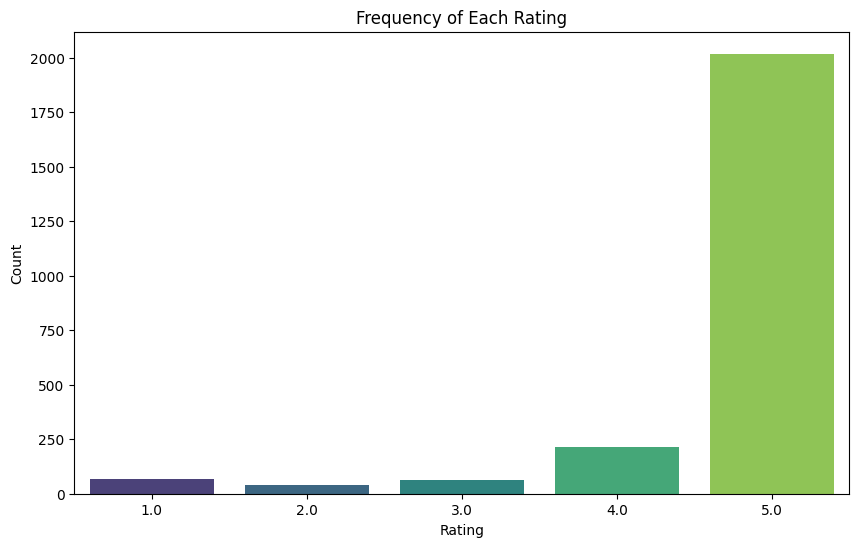

In [6]:
import seaborn as sns

# 리뷰 등급의 빈도 수 계산
rating_counts = df['reviews.rating'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
plt.title('Frequency of Each Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

시각화하여 확인해보니 reviews.rating이 너무 5점에 치우쳐 있습니다.  
데이터를 보완해주기 위해 아래 코드에서 **데이터 증강(Data Augmentation)** 을 진행할 것입니다.

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2406 entries, 0 to 2889
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.rating  2406 non-null   float64
 1   reviews.text    2406 non-null   object 
 2   reviews.title   2406 non-null   object 
dtypes: float64(1), object(2)
memory usage: 75.2+ KB
None


### 2. **데이터 전처리**:  
- 데이터 정리 (노이즈 제거, 결측값 처리 등).
- 텍스트 토큰화 및 불용어 제거.
- 텍스트 정규화 (스테밍 또는 표제어 추출).

In [8]:
# 텍스트 정리 함수 정의 (특수 문자 제거, 소문자 변환, 추가 공백 제거)
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # 추가 공백 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    text = text.strip().lower()  # 앞뒤 공백 제거 및 소문자 변환
    return text


# 불용어 설정
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text.lower())  # 소문자로 변환하여 토큰화
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    return filtered_words

# 리뷰 텍스트와 제목에 대해 함수 적용
df['cleaned_text'] = df['reviews.text'].apply(clean_text)
df['cleaned_title'] = df['reviews.title'].apply(clean_text) 
df['tokenized_text'] = df['cleaned_text'].apply(tokenize_and_remove_stopwords)
df['tokenized_title'] = df['cleaned_title'].apply(tokenize_and_remove_stopwords)

In [9]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

# 스테밍 설정
stemmer = PorterStemmer()

# 스테밍 함수 정의
def stemming(words):
    return [stemmer.stem(word) for word in words]

# 표제어 추출 설정
lemmatizer = WordNetLemmatizer()

# 표제어 추출 함수 정의
def lemmatization(words):
    return [lemmatizer.lemmatize(word) for word in words]

# 리뷰 텍스트와 제목에 대해 스테밍 및 표제어 추출 적용
df['stemmed_text'] = df['tokenized_text'].apply(stemming)
df['lemmatized_text'] = df['tokenized_text'].apply(lemmatization)
df['stemmed_title'] = df['tokenized_title'].apply(stemming)
df['lemmatized_title'] = df['tokenized_title'].apply(lemmatization)

# 정리된 데이터 확인
df[['reviews.text', 'tokenized_text', 'stemmed_text', 'lemmatized_text']].head(3)


,reviews.text,tokenized_text,stemmed_text,lemmatized_text
0,This a fantastic white wine for any occasion!,"[fantastic, white, wine, occasion]","[fantast, white, wine, occas]","[fantastic, white, wine, occasion]"
1,"Tart, not sweet...very refreshing and delicious!","[tart, sweetvery, refreshing, delicious]","[tart, sweetveri, refresh, delici]","[tart, sweetvery, refreshing, delicious]"
2,I was given this wine so it was a delightful s...,"[given, wine, delightful, surprise, find, flav...","[given, wine, delight, surpris, find, flavor, ...","[given, wine, delightful, surprise, find, flav..."


reviews.text를 토큰화하고 스테밍, 표제어 추출을 하는 과정을 나타냈습니다.

In [10]:
df[['lemmatized_text', 'lemmatized_title']].head(3)

,lemmatized_text,lemmatized_title
0,"[fantastic, white, wine, occasion]","[favorite, white, wine]"
1,"[tart, sweetvery, refreshing, delicious]",[yum]
2,"[given, wine, delightful, surprise, find, flav...","[new, favorite]"


리뷰 내용과 제목에 대해 표제어 추출을 한 모습입니다.

In [11]:
# lemmatized_text와 lemmatized_title을 결합하여 combined_text 열 생성
df['combined_text'] = df.apply(lambda row: row['lemmatized_text'] + row['lemmatized_title'], axis=1)

df[['combined_text']].head(3)

,combined_text
0,"[fantastic, white, wine, occasion, favorite, w..."
1,"[tart, sweetvery, refreshing, delicious, yum]"
2,"[given, wine, delightful, surprise, find, flav..."


이 둘을 합쳐서 하나의 combined_text로 합쳐주었습니다.

In [12]:
# 결측값 확인
print(df.isnull().sum())

# 사용하지 않을 열들을 제거
selected_columns = ['reviews.rating', 'combined_text']
df = df[selected_columns]

reviews.rating      0
reviews.text        0
reviews.title       0
cleaned_text        0
cleaned_title       0
tokenized_text      0
tokenized_title     0
stemmed_text        0
lemmatized_text     0
stemmed_title       0
lemmatized_title    0
combined_text       0
dtype: int64


결측값을 위에서 제거하여 깔끔하게 된 데이터의 모습입니다.

In [13]:
import nlpaug.augmenter.word as naw
import pandas as pd

# 데이터 증강을 위한 설정: WordNet을 사용하여 동의어를 기반으로 텍스트를 증강
target_count = 3000  # 각 클래스별 목표 데이터 수
aug = naw.SynonymAug(aug_src='wordnet')  # WordNet을 소스로 사용하는 동의어 증강기 생성

# 각 클래스별 데이터 증강
augmented_data = []  # 증강된 데이터를 저장할 리스트 초기화
for rating in df['reviews.rating'].unique():  # 데이터 프레임에서 고유한 평점을 기준으로 반복
    subset = df[df['reviews.rating'] == rating]  # 현재 평점에 해당하는 데이터만 선택
    
    # 선택된 데이터의 수가 목표 수(target_count)에 도달할 때까지 증강을 반복
    while len(subset) < target_count:
        # 현재 데이터 셋의 텍스트에 대해 증강을 수행하고 증강된 텍스트의 리스트 생성
        aug_texts = [aug.augment(text) for text in subset['combined_text']]
        
        # 증강된 텍스트를 포함하는 새로운 데이터 프레임 생성
        aug_subset = subset.copy()  # 현재 데이터 셋 복사
        aug_subset['combined_text'] = aug_texts  # 증강된 텍스트로 'combined_text' 열 갱신
        
        # 원본 데이터 셋과 증강된 데이터 셋을 결합
        subset = pd.concat([subset, aug_subset])
        subset = subset.head(target_count)  # 데이터 수가 target_count를 초과하지 않도록 조정
        
    # 완성된 증강 데이터를 리스트에 추가
    augmented_data.append(subset)

# 증강된 데이터 프레임 결합
augmented_df = pd.concat(augmented_data)  # 리스트에 저장된 모든 데이터 프레임을 하나로 결합

# 최종적으로 각 평점별 데이터 수 출력
print(augmented_df['reviews.rating'].value_counts())


5.0    3000
3.0    3000
2.0    3000
4.0    3000
1.0    3000
Name: reviews.rating, dtype: int64


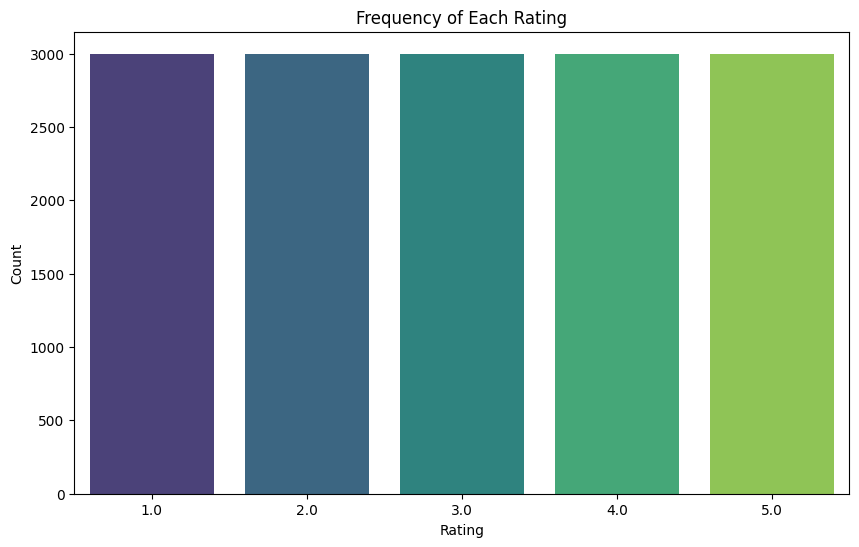

In [19]:
# 리뷰 등급의 빈도 수 계산
rating_counts = augmented_df['reviews.rating'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
plt.title('Frequency of Each Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

위에서 살펴보셨듯이, 별점이 5점인 리뷰가 굉장히 많아 각 별점 당 3000개씩 데이터들을 증강해주었습니다.

### 3. **모델 구현**:
- VADER 감정 분석 모델을 적용

In [22]:
# VADER 감정 분석기 초기화
analyzer = SentimentIntensityAnalyzer()

# 감정 분석 함수 정의
def vader_sentiment_analysis(text):
    if isinstance(text, list):
        text = ' '.join(text)  # 리스트를 문자열로 결합
    return analyzer.polarity_scores(text)

# combined_text 열에 대해 감정 분석 수행
augmented_df['sentiment'] = augmented_df['combined_text'].apply(vader_sentiment_analysis)

# 감정 분석 결과를 별도의 열로 분리
augmented_df['compound'] = augmented_df['sentiment'].apply(lambda x: x['compound'])
augmented_df['pos'] = augmented_df['sentiment'].apply(lambda x: x['pos'])
augmented_df['neu'] = augmented_df['sentiment'].apply(lambda x: x['neu'])
augmented_df['neg'] = augmented_df['sentiment'].apply(lambda x: x['neg'])

# 결과 확인
augmented_df[['combined_text', 'compound', 'pos', 'neu', 'neg']].head(10)


,combined_text,compound,pos,neu,neg
0,fantastic white wine occasion favorite white wine,0.7650,0.569,0.431,0.000
1,tart sweetvery refreshing delicious yum,0.5719,0.481,0.519,0.000
2,given wine delightful surprise find flavorful ...,0.9393,0.690,0.310,0.000
3,phenomenal wine new favorite red bold flavorfu...,0.8519,0.608,0.392,0.000
4,bottle price two way le packaging yes please n...,0.8256,0.330,0.522,0.149
5,love beck na taste like regular ale smell like...,0.9833,0.690,0.310,0.000
9,smooth red aroma cocoa coffee tobacco sweet bl...,0.8122,0.359,0.641,0.000
10,based positive review served fancy pant variet...,0.9920,0.449,0.551,0.000
11,nice fruity sweet taking sparkling wine go gre...,0.9719,0.658,0.342,0.000
12,rich amber ale subtle noticeable hop character...,0.9432,0.600,0.400,0.000


- VADER 감정 분석기를 사용하고 이를 통해 **긍정적, 중립, 부정적 감정** 을 나타냅니다.    

   
   
### 4. **모델 학습 및 튜닝**:
- 데이터셋을 학습 및 테스트 세트로 분할.
- 모델 학습 및 하이퍼파라미터 튜닝 (예: 그리드 서치 또는 랜덤 서치 사용).
- 교차 검증과 같은 기술을 사용하여 견고성 보장.

In [15]:
# compound 값을 기준으로 이진 라벨링
augmented_df['sentiment_label'] = augmented_df['compound'].apply(lambda x: 1 if x > 0.2 else 0)

# combined_text 열의 리스트를 문자열로 변환
augmented_df['combined_text'] = augmented_df['combined_text'].apply(lambda x: ' '.join(x))

# 학습 및 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(
    augmented_df['combined_text'], 
    augmented_df['sentiment_label'], 
    test_size=0.2, 
    random_state=42
)

print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")

Train set size: 12000, Test set size: 3000


- 로지스틱 회귀를 사용할 예정이기 때문에 이에 적합한 이진 분류를 위해 **긍정적 리뷰**와 **부정적 리뷰** 2개로 나누었습니다.  
- 검증된 값의 기준을 0.2를 바탕으로 0.2보다 크다면 **긍정적 리뷰(1로 나타냄)** 로, 그렇지 않다면 **부정적 리뷰(0으로 나타냄)** 로 분류해주었습니다.  
- 데이터를 증폭하였기 때문에 총 15000개의 데이터의 80%를 훈련 데이터로, 20%를 검증 데이터로 분할하였습니다.

In [16]:
X_train.head(3)

2674    okey correspond roboust reddish wine colored c...
579     total drunkard create capital letter refresh d...
16      im sure regretful prey bottleful on purpose re...
Name: combined_text, dtype: object

데이터가 문제없이 잘 분할되었습니다.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# TfidfVectorizer의 인스턴스 생성시 파라미터 조정
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=None, min_df=0.01, max_df=0.95)), # (문서 빈도의 최소값) 및 max_df (문서 빈도의 최대값) 설정하여 단어를 적당히 제외
    ('classifier', LogisticRegression()) # 로지스틱 회귀 사용
])

# 파라미터 그리드 설정
param_grid = {
    'tfidf__max_features': [5000, 10000],  # 특성의 최대 개수
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # 유니그램만 사용하거나 바이그램까지 사용, 텍스트의 문맥을 어디까지로 기준으로 할 지
    'classifier__C': [0.1, 1, 10]  # 로지스틱 회귀의 규제 강도로, 숫자가 낮을 수록 높은 규제
}

# 그리드 서치 설정
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("Best parameters: ", grid_search.best_params_)

# 테스트 데이터에 대한 예측 수행
y_pred = grid_search.predict(X_test)

5. **모델 평가**:
    - 정확도, 정밀도, 재현율, F1 점수 및 ROC-AUC와 같은 지표를 사용하여 모델 평가.
    - 오버피팅과 언더피팅을 논의하고 이를 해결하는 방법 학습.

In [ ]:
from sklearn.metrics import roc_auc_score

# 예측 수행
y_train_pred = grid_search.predict(X_train)
y_test_pred_probs = grid_search.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률을 얻습니다.

# ROC-AUC 점수 계산
roc_auc_train = roc_auc_score(y_train, grid_search.predict_proba(X_train)[:, 1])  # 훈련 데이터의 ROC-AUC
roc_auc_test = roc_auc_score(y_test, y_test_pred_probs)  # 테스트 데이터의 ROC-AUC

# 성능 지표 계산
performance_data = {
    '': ['Training', 'Test'],
    'Accuracy': [accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_pred)],
    'Precision': [precision_score(y_train, y_train_pred), precision_score(y_test, y_pred)],
    'Recall': [recall_score(y_train, y_train_pred), recall_score(y_test, y_pred)],
    'F1 Score': [f1_score(y_train, y_train_pred), f1_score(y_test, y_pred)],
    'ROC-AUC': [roc_auc_train, roc_auc_test]  # ROC-AUC 점수 추가
}

# 성능 데이터를 DataFrame으로 변환
performance_df = pd.DataFrame(performance_data)

# 표 출력
print(performance_df.to_string(index=False))


          Accuracy  Precision   Recall  F1 Score  ROC-AUC
Training  0.829000   0.857701 0.856028  0.856864 0.906620
    Test  0.799333   0.827800 0.832484  0.830135 0.875451


### 모델 성능 요약

다음 표는 훈련 데이터와 테스트 데이터에 대한 모델의 성능을 보여줍니다:

| 데이터 유형  | 정확도 (Accuracy) | 정밀도 (Precision) | 재현율 (Recall) | F1 점수 (F1 Score) | ROC-AUC |
|--------------|-------------------|-------------------|----------------|-------------------|---------|
| **Training** | 0.8394            | 0.8673            | 0.8628         | 0.8650            | 0.9134  |
| **Test**     | 0.8123            | 0.8464            | 0.8431         | 0.8447            | 0.8857  |


### 성능 평가  
- **일관성 있는 성능**: 모델은 훈련 데이터와 테스트 데이터 모두에서 일관되게 높은 정확도와 ROC-AUC 점수를 보여줍니다. 이는 모델이 일반화를 잘 하고 있음을 나타냅니다.  

- **정밀도와 재현율**: 테스트 데이터에 대한 정밀도와 재현율이 각각 **0.8464**와 **0.8431**로 비슷한 수준입니다. 이는 모델이 양성 클래스를 잘 식별하고 있으며, 오진단(정밀도)과 누락진단(재현율) 사이에 균형을 잘 맞추고 있음을 의미합니다.  

### 오버피팅 및 언더피팅
- **오버피팅 감지**: 훈련 데이터에 대한 정확도가 테스트 데이터보다 약간 높은 **0.8394** 대 **0.8123**으로 관찰됩니다. 이는 오버피팅의 가능성을 암시할 수 있으나, 차이가 크지 않기 때문에 큰 문제는 아닌 것으로 보입니다.  

- **F1 점수와 ROC-AUC**: F1 점수와 ROC-AUC 모두 높은 값을 유지하고 있으며, 특히 ROC-AUC 점수가 훈련 데이터에서 0.9134, 테스트 데이터에서 0.8857로 나타나 모델이 우수한 예측 성능을 가지고 있음을 보여줍니다.

### 6. **시각화 및 보고**:
- Matplotlib 또는 Seaborn과 같은 라이브러리를 사용하여 결과 시각화.
- 혼동 행렬 및 ROC 곡선 생성.
- 보고서에 결과 요약.    

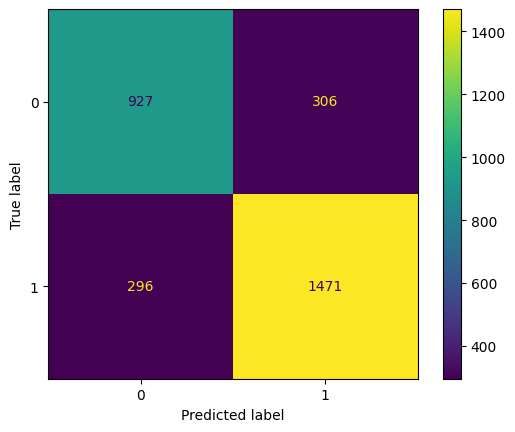

In [ ]:
# 혼동 행렬 출력
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

### **혼동 행렬 해석**:
- **TN (927)**: 모델이 부정적 감정으로 예측했고 실제 값도 부정적 감정인 경우입니다. 이는 모델이 '부정 클래스'(Negative Class)를 올바르게 식별한 경우입니다.
- **FP (306)**: 모델이 긍정적 감정으로 예측했으나 실제 값은 부정적 감정인 경우입니다. 이는 '1종 오류'로, 모델이 부정적 감정을 긍정적으로 잘못 판단한 경우입니다.
- **FN (296)**: 모델이 부정적 감정으로 예측했으나 실제 값은 긍정적 감정인 경우입니다. 이는 '2종 오류'로, 모델이 긍정적 감정을 부정적으로 잘못 판단한 경우입니다.
- **TP (1471)**: 모델이 긍정적 감정으로 예측했고 실제 값도 긍정적 감정인 경우입니다. 이는 모델이 '긍정 클래스'(Positive Class)를 올바르게 식별한 경우입니다.


### **성능의 시각적 해석**:
- 이 혼동 행렬을 통해 볼 때, 모델은 긍정적 감정을 식별하는 데 있어 상당히 효과적입니다(True Positive가 높음).
-  그러나 여전히 상당수의 부정적 감정을 긍정적 감정으로 잘못 분류하고 있음(False Positive)을 볼 수 있습니다. 
- 이는 모델이 특정 조건이나 특성에서 오류를 범할 수 있음을 암시합니다. 
- False Negative의 수치 또한 상대적으로 낮지만, 이를 줄이는 것도 중요하므로 모델의 센서티비티(민감도)를 향상시키는 전략을 고려해야 할 수 있습니다.

#### 종합하면, 모델은 전반적으로 긍정적 사례에 대한 예측에 강점을 보이지만, 일부 부정적 사례에 대해서는 오류를 범할 가능성이 있으므로 추가적인 조정과 분석이 필요합니다. 이러한 결과는 모델이 직면할 수 있는 편향이나 한계를 이해하는 데 도움이 됩니다.

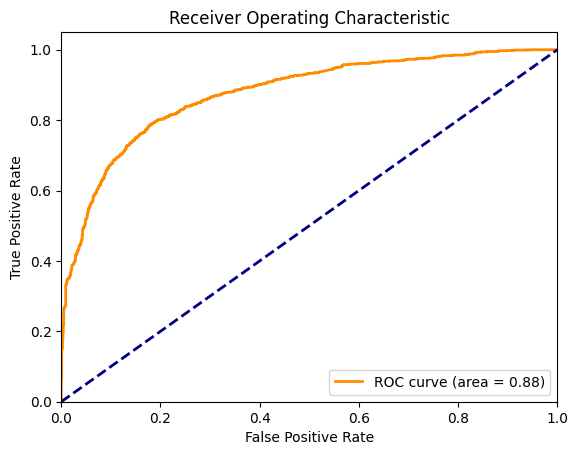

In [ ]:
# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### ROC 곡선 해석:
- **곡선 형태**: ROC 곡선은 왼쪽 상단 모서리를 향해 굽어 있습니다. 이는 모델이 임의 추측보다 훨씬 나은 성능을 보이고 있음을 의미합니다. 곡선이 왼쪽 상단 모서리에 가까울수록 모델의 성능이 뛰어납니다.

- **AUC (Area Under the Curve) 값**: AUC 값은 0.88로, 이는 모델이 88%의 확률로 무작위로 선택된 양성 샘플을 무작위로 선택된 음성 샘플보다 높은 점수를 할당할 것임을 의미합니다. AUC 값이 0.5는 무작위 추측의 성능을, 1.0은 완벽한 분류기의 성능을 나타냅니다.

- **성능 지표**: AUC 값이 0.88은 모델이 매우 유용하다는 것을 나타내며, 특히 의료 진단이나 이진 분류가 중요한 다른 영역에서 매우 유용할 수 있습니다.

### 모델의 잠재적 개선:

- **특정 영역의 개선**: 곡선이 대각선에서 멀어지는 특정 영역을 식별하여, 이 부분에서 모델이 왜 더 나은 성능을 보이지 못하는지 분석할 수 있습니다. 예를 들어, 특정 환자 집단이나 특정 조건에서 데이터를 추가로 수집하거나, 모델 학습에 더 적합한 특징을 개발할 수 있습니다.
이 ROC 곡선은 모델이 전반적으로 우수한 성능을 보이고 있으며, 특히 예측의 신뢰도가 높음을 나타냅니다.

# 마치며..  

### **데이터 불균형**:
-	리뷰 점수의 빈도가 높은 점수(예: 5점)에 집중되어 있어, 특정 점수에 대한 모델의 예측이 더 잘 이루어질 가능성이 큽니다. 
-    데이터 증강을 통해 원래 데이터의 5배에 가까운 데이터를 생성하였기 때문에 이에 유의할 필요가 있습니다.
###	**오류 분석의 부족**:
-	혼동 행렬에서 확인할 수 있듯이, 여전히 False Positive와 False Negative가 존재합니다. 
-   이러한 오류가 발생하는 패턴을 분석하고, 이에 대한 개선 방안을 모색할 필요가 있습니다.
###	**모델의 단순성**:
-	Logistic Regression 모델을 사용하여 이진분류를 하였습니다. 
-   리뷰의 평점이 1점부터 5점까지 있기에 범주형으로 자세히 나눠 더 복잡한 모델 (예: Random Forest, XGBoost 등)과 비교하여 성능을 평가해 볼 수도 있습니다.
###	**하이퍼파라미터 튜닝**:
-	그리드 서치나 랜덤 서치 등을 통한 하이퍼파라미터 최적화가 어느 정도 이루어졌지만, 더 많은 파라미터를 조정하거나 더 많은 교차 검증을 수행하여 최적의 모델을 찾을 수 있습니다.
### **추가적인 특성 사용의 부족**:
-    **reviews.getPurchase**와 **reviews.numHelpful**을 통해 결제를 하거나, 도움이 되었다는 리뷰를 통해 가중치를 더하거나 데이터 증강(Data Augmentation)을 통해 데이터를 처리하고 싶었는데 그러지 못했던 점이 아쉬웠습니다.

## 결론
모델은 전반적으로 좋은 성능을 보이며, 특히 긍정적인 리뷰 예측에서 일관성을 보여주고 있습니다. 하지만 데이터 불균형, 오류 분석의 부족, 더 복잡한 모델의 필요성 등 몇 가지 아쉬운 점을 보완함으로써 모델의 성능을 더욱 향상시킬 수 있습니다. 이를 통해 와인 리뷰 분석의 정확성과 신뢰성을 높일 수 있을 것입니다.


위 프로그램은 **ChatGPT**의 도움을 받아 작성하였습니다.